In [2]:
###########################################################################
#                                                                         #
#         Project 5: Social Media Data Analysis, with BlueSky             #
#                                                                         #
#                      Author : Stephen Bouchardon                        #
#                                                                         #
###########################################################################

"""

Modules

"""

from atproto import *
from dotenv import load_dotenv
from os import getenv, makedirs
import pandas as pd
from textblob import TextBlob
import re
from collections import Counter
import matplotlib.pyplot as plt
import datetime as dt


In [3]:
###########################################################################
#                                                                         #
# Pre-loading                                                             #
# Functions : loginClient, fetchPosts, getInfoPost                        #
#                                                                         #
###########################################################################

"""
Function: loginClient 

Logs in to the Bluesky social media using credentials from a .env file. 

Link documentation : https://docs.bsky.app/docs/get-started, https://docs.bsky.app/docs/starter-templates/bots

Parameters: None

Returns:
* client: Authenticated Bluesky session object
"""
def loginClient():

    load_dotenv() # load in the private credentials from .env file (email and password)

    bluesky_email = getenv("BLUESKY_EMAIL")
    bluesky_pwd = getenv("BLUESKY_PWD")

    client = Client() # login to the bluesky account via the api : atproto
    client.login(bluesky_email,bluesky_pwd)
    
    return client



"""
Function: fetchPosts

Fetches targetted posts from Bluesky based on search parameters.

Link documentation : https://docs.bsky.app/docs/api/app-bsky-feed-search-posts

Parameters:
* client : Bluesky session object
* q: Search the string tag or hastag inside the text value of the post, format: "#{value}"
* sort: Ranking values by "latest" or "top"
* limit: Maximum number of posts retrieved, format: integer
* since: Starting date of search (inclusive), ISO format: "YYYY-MM-DDTHH:MM:SSZ"
* until: Ending date of search (exclusive), ISO format: "YYYY-MM-DDTHH:MM:SSZ"
* lang: Language of the search (e.g. "en", "fr")
* optionPrint: Boolean to print the data collected

Returns:
* df: Pandas DataFrame of post metadata (author, URI, text, timestamp)
"""
def fetchPosts(client, q="#football", sort="top",limit=100, since="2025-01-01T00:00:00Z", until="2025-06-01T00:00:00Z",lang="en",optionPrint=True):
    # prepare a dictionnary to search the requested posts 
    search_params = {
        "q": q,  
        "sort": sort,
        "limit": limit, 
        "since" : since,
        "until" : until,
        "lang" : lang
    }

    # try to get the posts
    response = client.app.bsky.feed.search_posts(search_params)

    # get response 200 : client's request valid
    # from response, collect data in a list of dictionaries
    data = []

    for post in response.posts:
        post_record = post.record
        post_data = {
            "post_did": post.author.did,
            "post_uri": post.uri,
            "author": post.author.display_name,
            "handle": post.author.handle,
            "author_did": post.author.did,
            "text": post_record.text,
            "created_at": post_record.created_at
        }
        
        # add post values ( a dictionary ) to the list
        data.append(post_data)

    # convert list to DataFrame
    df = pd.DataFrame(data)

    if(optionPrint==True):
        print(df)
    return df


   
"""
Function: getInfoPost

Slice a DataFrame : accesses the i rows and j columns of a larger DataFrame.

Parameters:
* df: Pandas DataFrame
* i: Row index
* j: Column index

Returns:
* Subset of the DataFrame
"""
def getInfoPost(df,i,j):
    iMax, jMax = df.shape
    i = min(i, iMax - 1) # if the i index is greater than the row size of the DataFrame, retrieve the last row of the DataFrame instead
    j = min(j, jMax - 1)
    return df.iloc[i, j]


In [4]:
#################################################################################################
#                                                                                               #
# 1. Derive the sentiment of each post using Python modules (no need to create your Algorithm): #
# Functions : get_polarity, categorize_polarity, get_likes, get_sentimentAnalysis               #
#                                                                                               #
#################################################################################################

"""
Function: get_polarity

From the library TextBlob and its sentiment analysis tools, 
the function calculate the polarity score within the range [-1.0, 1.0]. 
A better score is positive and tends to 1.0. If worse, to -1.0.

Link documentation : https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis

Parameters:
* text : string of characters

Returns:
* Float value between -1.0 and 1.0
"""
def get_polarity(text):
    return TextBlob(text).sentiment.polarity



"""
Function: categorize_polarity

Categorizes a post into sentiment type based on their polarity score.

Parameters:
* p: Float value, the polarity score found for a post with the function get_polarity

Returns:
* "positive", "negative" or "neutral"
"""
def categorize_polarity(p):
    if p > 0:
        return 'positive'
    elif p < 0:
        return 'negative'
    else:
        return 'neutral'



"""
Function: get_likes

With the URI of a post, the client object retrieves the like records and find the number of likes.

Link documentation : https://docs.bsky.app/docs/api/app-bsky-feed-get-likes

Parameters:
* client : Bluesky session object
* uri : Unique identifier of the post

Returns:
* Integer value, number of likes
"""
def get_likes(client, uri):
    response = client.app.bsky.feed.get_likes({"uri": uri})
    return len(response.likes)



"""
Function: get_sentimentAnalysis

Apply the functions get_polarity & get_likes for a dataset of posts.
Create a new DataFrame with the id of the post and its sentimental scores.
Finally, sort the DataFrame by polarity and number of likes.
Optionally, plots polarity vs likes and sentiment distribution.

Parameters:
* client: Bluesky session object
* df: Pandas DataFrame of posts
* optionPlot: Boolean to plot results
* optionPrint: Boolean to print the data collected

Returns:
* returnedDf: Sorted DataFrame of post URI, polarity, category and likes
"""

def df_sentimentAnalysis(client, df, optionPrint=True, optionPlot=True):
    # initialisation of the new dataframe
    df_postAnalysis = pd.DataFrame()
    df_postAnalysis['post_uri'] = df['post_uri']
    df_postAnalysis['polarity'] = df['text'].apply(get_polarity)
    df_postAnalysis['category'] = df_postAnalysis['polarity'].apply(categorize_polarity) # regroup per category the polarity in the dataframe
    df_postAnalysis['likes'] = df['post_uri'].apply(lambda uri: get_likes(client, uri))
    
    # sort by likes and sentiment polarity
    # the posts with the most likes and a more positive text will appear at the top of the DataFrame
    df_postAnalysisSorted = df_postAnalysis.sort_values(by=['likes', 'polarity'], ascending=False)

    # if optionPloting is true, create a copy of the ordered df because of the categorised polarties
    returnedDf = df_postAnalysisSorted

    if(optionPrint==True):
        print(returnedDf)
        
    if(optionPlot==True):
        
        plt.figure(figsize=(10, 6))
        plt.scatter(df_postAnalysisSorted['polarity'], df_postAnalysisSorted['likes'], alpha=0.7)
        plt.title('Sentiment Analysis on posts : polarity vs likes')
        plt.xlabel('Sentiment Polarity')
        plt.ylabel('Number of Likes')
        plt.grid(True)
        plt.show()
        

        # count the total for each type of polarity
        sum_polarity = df_postAnalysisSorted['category'].value_counts()
        
        # get counting in desired order
        category_polarity = [
            sum_polarity.get('negative', 0),
            sum_polarity.get('neutral', 0),
            sum_polarity.get('positive', 0)
        ]

        plt.figure(figsize=(8, 6))
        plt.bar(['Negative', 'Neutral', 'Positive'], category_polarity)
        plt.title('Total Polarity per post')
        plt.ylabel('Total')
        plt.grid(axis='y')
        plt.show()

    return returnedDf
    

In [5]:
#############################################################################
#                                                                           #
# 2. Top 10 tags and users based on their number of posts in your data set: #
# Functions : get_top_tags, get_top_users_most_posts, df_top_tags_users     #
#                                                                           #
#############################################################################

"""
Function: get_top_tags

Finds and ranks the n most frequently used tags.
We exclude the the top one, as it is the query tag and would not give any more new information on the posts.

Parameters:
* df: Pandas DataFrame of posts
* n: Number of tags to return 

Returns:
* top_tags: List of (tag_name, tag_count) tuples
"""
def get_top_tags(df,n=10):
    # find the top 10 tags from the data set, except #football:
    all_tags = df['text'].apply(lambda text: re.findall(r"#\w+", text.lower()))
    all_tags = [tag for sublist in all_tags for tag in sublist]
    
    # Count frequency
    tag_counts = Counter(all_tags)

    # remove the top count, it is the tag we used a as common subject for all the posts in the fetched data
    remv_tag, _ = tag_counts.most_common(1)[0]
    del tag_counts[remv_tag]

    # take only the n firsts
    top_tags = tag_counts.most_common(n)
    return top_tags


"""
Function: get_top_users_most_posts

Finds and ranks the n users most frequently posting.

Parameters:
* df: Pandas DataFrame of posts
* n: Number of users to return 

Returns:
* Pandas Series of top users
"""
def get_top_users_most_posts(df,n=10): 
    # find the top n users from the data set with the most posts
    return df['author'].value_counts().head(n)



"""
Function: df_top_tags_users

Creates a DataFrame for the top users and tags.
Optionally, plots charts for the top tags and users.

Parameters:
* df: Pandas DataFrame of posts
* n: Number of top users/tags
* optionPlot: Boolean to plot results
* optionPrint: Boolean to print the data collected

Returns:
* top_data: Combined DataFrame of top tags and top users

"""
def df_top_tags_users(df,n=10,optionPlot=True,optionPrint=True):

    # init top tags and users
    top_tags = get_top_tags(df)
    top_users = get_top_users_most_posts(df)
    
    # Create two separate DataFrames
    df_top_tags = pd.DataFrame(top_tags, columns=["tag", "nb_tags"])
    
    df_top_users = top_users.reset_index()
    df_top_users.columns = ["user", "nb_posts_by_user"]
    
    # Combine into one DataFrame (for display purposes)
    top_data = pd.concat([df_top_users, df_top_tags], axis=1)

    if(optionPrint == True):
        print(top_data)
        
    if(optionPlot == True):

        # Tags 
        # Link : http://www.python-simple.com/python-matplotlib/pie.php
        tags, counts = zip(*top_tags)
        plt.figure(figsize = (8, 8))
        plt.pie(counts, labels = tags,
        autopct = lambda counts: str(round(counts, 2)) + '%',
        pctdistance = 0.7, labeldistance = 1.3)
        plt.title(f"Top {n} tags")
        plt.legend(loc='upper left')
        plt.show()
        
        # Users
        top_users.plot(kind='bar', color='skyblue', title=f"Top {n} users per posting")
        plt.ylabel("Number of posts")
        plt.xticks(rotation=45)
        plt.xlabel("")
        plt.grid(True, axis='y', linestyle='--')
        plt.show()
        
    return top_data
    

In [6]:
##################################################################################
#                                                                                #
# 3. Get the followers of a given social media user from your acquired data set: #
# Functions : get_top_user, getFollowers                                         # 
#                                                                                #  
##################################################################################

"""
Function: getFollowers

Fetches a limited list of followers for a given user.

Link documentation : https://docs.bsky.app/docs/api/app-bsky-graph-get-followers

Parameters:
* client: Bluesky session object
* user_did: Unique identifier for the user
* df: DataFrame containing post and author info
* limit : Maximum number of followers to fetch within the range [1,100]
* optionPrint : Boolean to print follower names

Returns:
* followers: List of follower objects
* following_name: Display name of the targetted user
"""
def getFollowers(client,user_did,df,limit=50,optionPrint=True):
    
    # Fetch followers
    response = client.app.bsky.graph.get_followers({'actor': user_did,'limit': limit})
    
    # Extract follower information
    followers = response.followers

    following_name = (df[df['author_did'] == user_did])['author'].iloc[0]
    
    if(optionPrint == True): 
        # Display follower author names:
        print(f"Followers of {following_name} :")
        
        countFollowers=0
        for countFollowers,follower in enumerate(followers):
            print(f"{countFollowers} : {follower.display_name or follower.handle}") 
            # some users do not have displayed name. In that case, print their handle.
        print(f"Total count of followers = {countFollowers+1}")
    
    return followers, following_name


"""
Function: get_top_user

Retrieves from the Top users DataFrame, the user that has the most posts in our intial dataset.

Parameters:
* df_posts: DataFrame containing posts information
* df_top: DataFrame containing the top users information

Returns:
* Unique identifier of the top user
"""
def get_top_user(df_posts, df_top):
    top_user_name = df_top['user'].iloc[0] # find the top users name in the top users dataframe, make sure it is valid
    return df_posts.loc[df_posts['author'] == top_user_name, 'author_did'].iloc[0] 


In [7]:
#########################################################################################################
#                                                                                                       #
# 4. Given a social media user, obtain the posts and profiles of all followers of the user and show it: #
# Functions : get_profile, get_recent_posts, df_followers                                               #
#                                                                                                       #  
#########################################################################################################


"""
Function get_profile: 

Send API request to fetch detailed profile view of an actor and its metadata.

Parameters:
* client: Bluesky session object
* user_did: Unique identifier for the user

Returns:
* Detailed profile view of an actor
"""
# function to get profile of a user
def get_profile(client, user_did):
    return client.app.bsky.actor.get_profile({'actor': user_did})



"""
Function get_recent_posts: 

.

Parameters:
* :

Returns:
* :
"""
# function to get recent posts of a user, max limit is 5
def get_recent_posts(client, user_did, limit=5):
    response = client.app.bsky.feed.get_author_feed({'actor': user_did, 'limit': limit})
    return response.feed



"""
Function df_followers: 

.

Parameters:
* :

Returns:
* :
"""
# add a list to store follower information, then transform into df
def df_followers(client, followers, limit=5,optionPrint=True):

    follower_data = []
    
    for follower in followers:
        follower_did = follower.did
        profile = get_profile(client,follower_did)
        posts = get_recent_posts(client,follower_did, limit=5)
        
        follower_info = {
            'display_name': profile.display_name,
            'handle': profile.handle,
            'avatar_url': profile.avatar,
            'description': profile.description,
            'followers_count': profile.followers_count,
            'following_count': profile.follows_count,
            'posts_count': profile.posts_count,
        }
        
        follower_data.append(follower_info)
    
    # create a DataFrame
    df_followers = pd.DataFrame(follower_data)
    
    # display the DataFrame
    if(optionPrint == True):
        print(df_followers)

    return df_followers


Write down the topic you want to search:                #


Result : #
Invalid input. Please use only 1 to 20 alphabetical characters.


Write down the topic you want to search:                    


Result : 
Invalid input. Please use only 1 to 20 alphabetical characters.


Write down the topic you want to search:   


Result : 
Invalid input. Please use only 1 to 20 alphabetical characters.


Write down the topic you want to search:  


Result : 
Invalid input. Please use only 1 to 20 alphabetical characters.


Write down the topic you want to search:  "r!yàh'gprezjhifnrg


Result : "r!yàh'gprezjhifnrg
Invalid input. Please use only 1 to 20 alphabetical characters.


Write down the topic you want to search:  f"&çazojfehgzipjoqsmd


Result : f"&çazojfehgzipjoqsmd
Invalid input. Please use only 1 to 20 alphabetical characters.


Write down the topic you want to search:  gayfuck


Result : gayfuck
                            post_did  \
0   did:plc:h6o4nkhxb24l5tousvtzwp7j   
1   did:plc:hgoqyomkidu27sworeh5rzij   
2   did:plc:hgoqyomkidu27sworeh5rzij   
3   did:plc:h2xrqtgs6v6fyv76dnlrtlu6   
4   did:plc:v27xlep4v6h3bhasdv3t55by   
..                               ...   
93  did:plc:a2ffzt6lh4r74x7kqlxwsufq   
94  did:plc:gma6rbe5pwiqvb6t4ddrefba   
95  did:plc:cbkdbosvaa5ev33hfipkceqf   
96  did:plc:hgoqyomkidu27sworeh5rzij   
97  did:plc:cbkdbosvaa5ev33hfipkceqf   

                                             post_uri                 author  \
0   at://did:plc:h6o4nkhxb24l5tousvtzwp7j/app.bsky...  Alasdair 🏴󠁧󠁢󠁳󠁣󠁴󠁿 🏳️‍🌈   
1   at://did:plc:hgoqyomkidu27sworeh5rzij/app.bsky...               Binash96   
2   at://did:plc:hgoqyomkidu27sworeh5rzij/app.bsky...               Binash96   
3   at://did:plc:h2xrqtgs6v6fyv76dnlrtlu6/app.bsky...                          
4   at://did:plc:v27xlep4v6h3bhasdv3t55by/app.bsky...                    R.A   
..                    

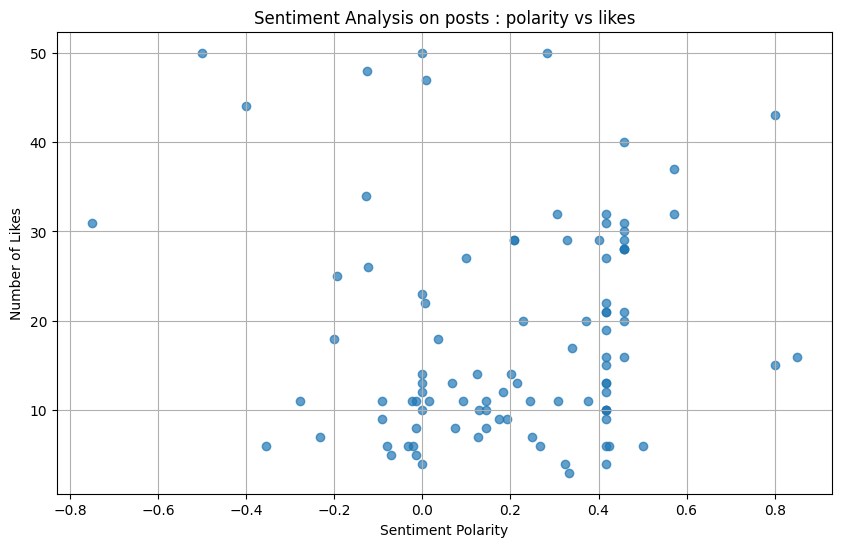

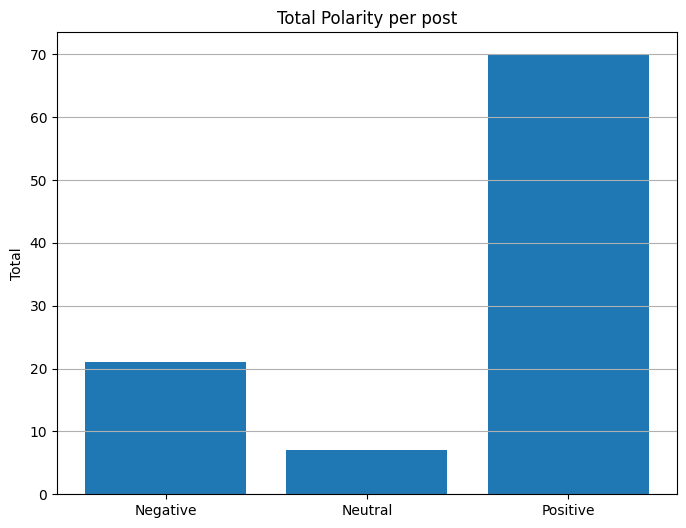

             user  nb_posts_by_user        tag  nb_tags
0       xxxelfgay                18       #gay       69
1                                15    #gaysex       67
2        Binash96                15  #bareback       42
3   Uncle Squirts                 6   #gayporn       42
4         Phrozen                 4      #fuck       25
5  safado showoff                 4      #porn       23
6          Gayboy                 2    #bottom       22
7      GayDrawing                 2     #twink       22
8  Yeah Baby Yeah                 2      #cock       22
9        ze Twink                 2      #nsfw       22


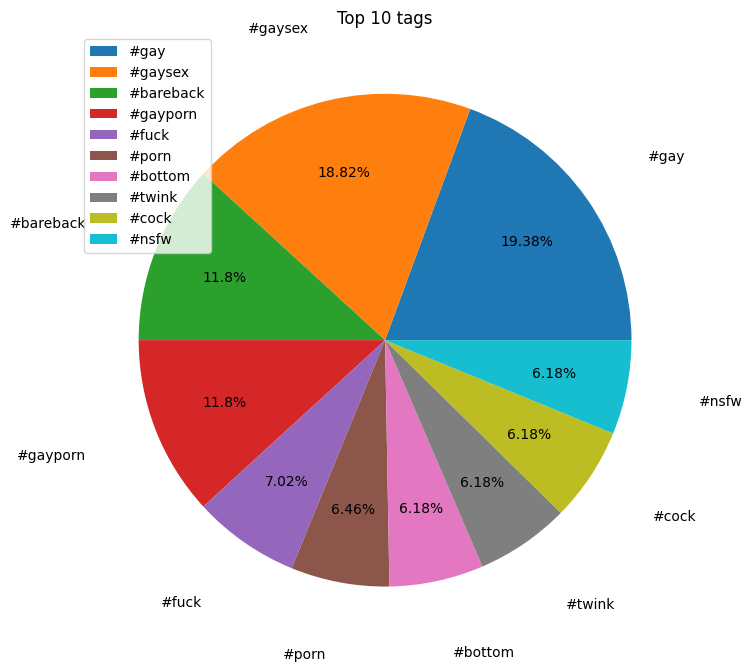

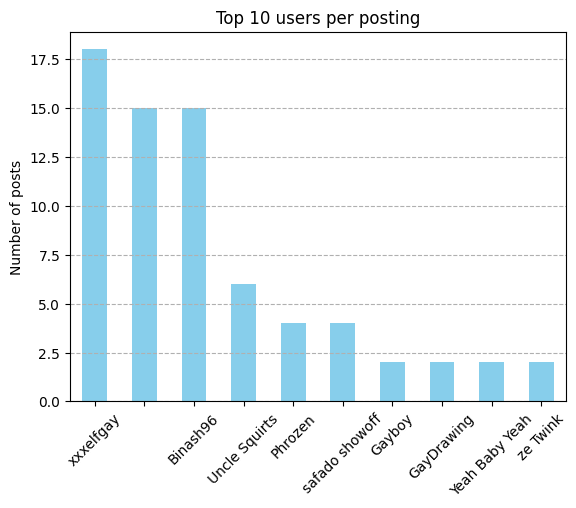

Followers of xxxelfgay :
0 : nik38.bsky.social
1 : viewinglight.bsky.social
2 : Blaire 💅
3 : Hylan
4 : ROYCE
5 : jerry121604.bsky.social
6 : simosharp.bsky.social
7 : myman2000.bsky.social
8 : Sebrof
9 : Swiss Jay XXX 1K (gay/bi/pan)🇨🇭💦
10 : incel anónimo: célibe involuntario
11 : brightboy1345.bsky.social
12 : nicholshurls.bsky.social
13 : lifeofpw.bsky.social
14 : freedomfire.bsky.social
15 : himesu02.bsky.social
16 : willstarr.bsky.social
17 : aed92.bsky.social
18 : Rowdy Bottom
19 : destroyedhumanoid.bsky.social
20 : muhap.bsky.social
21 : lualoandi1555.bsky.social
22 : Fin
23 : whiteboi24.bsky.social
24 : odyrunoo.bsky.social
25 : mcgriff127.bsky.social
26 : Random Gay Porn
27 : egytopman.bsky.social
28 : circj89.bsky.social
29 : Rebis Colorado
30 : justmyotheralt.bsky.social
31 : Jeff
32 : romanroyce.bsky.social
33 : gulikopokie1.bsky.social
34 : dorian-norde.bsky.social
35 : toppgunn69.bsky.social
36 : chaosus159.bsky.social
37 : Orcx Raw 🍆👹
38 : alexmaximoff.bsky.social
39 : ny

In [8]:
#########################################################################################################
#                                                                                                       #
# Testing cell                                                                                          #
# Functions : get_query, main                                                                           #
#                                                                                                       #  
#########################################################################################################



"""
Function get_query: 

.

Parameters: None

Returns:
* q : query used to search for the topic
"""
def get_query():
    pattern = re.compile(r'^[A-Za-z]{1,20}$')

    while True:
        q = input("Write down the topic you want to search: ")
        
        if pattern.fullmatch(q.strip()):
            return q
        else:
            print("Invalid input. Please use only 1 to 20 alphabetical characters.")



"""
Function main: 

.

Parameters: None

Returns: None
"""
def main():
    # pre loading #

    # connect to the Client with the BlueSky API
    client = loginClient()

    # Make sure the format is correct for the text query
    query = get_query()

    # Get the instant time in ISO Format for the following search date query in fetchPosts
    untilTime = dt.datetime.now().replace(microsecond=0).isoformat() + 'Z'

    df_posts = fetchPosts(client,
                          q=query,
                          sort="top",
                          limit=100,
                          since="2025-01-01T00:00:00Z",
                          until=untilTime,
                          lang="en")
    
    # 1 #
    df_posts_sentiment = df_sentimentAnalysis(client,df_posts)

    # 2 #
    df_top = df_top_tags_users(df_posts,10)

    # 3 #
    top_user_did = get_top_user(df_posts, df_top)
    top_user_followers, top_user_name = getFollowers(client,top_user_did,df_posts,100)

    # 4 #
    df_top_user_followers = df_followers(client, top_user_followers)

    # Create a directory if it does not exist yet to export the data
    dir_name = f"res_{query}_{untilTime}"
    makedirs(dir_name, exist_ok=True)

    # DataFrames -> .csv files
    df_posts.to_csv(f"{dir_name}/output_posts.csv", index=False)
    df_posts_sentiment.to_csv(f"{dir_name}/output_posts_sentiment.csv", index=False)
    df_top.to_csv(f"{dir_name}/output_top_tags_users.csv", index=False)
    df_top_user_followers.to_csv(f"{dir_name}/output_top_user_followers.csv", index=False)
    
    print("ok")

main()

# fetch posts of the followers !!! report inside a df with the author name, author did, list of posts did
# add in report : makedirs, datetime module, add function get_top_user, Basic date and time types.